# basic model


In [1]:
import argparse
import sys
from torchvision.datasets import MNIST
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN,Sigmoid
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp

In [2]:
cp.random.seed(42)

train_dataset = MNIST(
        root="dataset",
        train=True,
        transform=basic_mnist_augment(train=True),
        download=False
    )
test_dataset = MNIST(
    root="dataset",
    train=False,
    transform=basic_mnist_augment(train=False),
    download=False
)

In [3]:
import numpy as np
train_images, train_labels = preprocess(train_dataset)
test_images,  test_labels  = preprocess(test_dataset)
# 
# train_images = train_images.astype(np.float32) / 255.0
# test_images = test_images.astype(np.float32) / 255.0


train_set = (train_images[:50000], train_labels[:50000])

dev_set   = (train_images[50000:], train_labels[50000:])
test_images = cp.asarray(test_images)
test_labels = cp.asarray(test_labels)
test_set  = (test_images, test_labels)

In [4]:
import numpy as np
print("Min pixel value:", cp.min(test_images))
print("Max pixel value:", cp.max(test_images))

Min pixel value: 0.0
Max pixel value: 1.0


In [6]:
model= Model().load_model('best_model_basic/minst_base_lenet/best_model.pickle')

Model loaded from: best_model_basic\minst_base_lenet\best_model.pickle


In [7]:
loss_fn = CrossEntropy(model=model)
runner = RunnerM(model=model, loss=loss_fn, optimizer=None)

test_loss, test_acc = runner.evaluate(test_set, batch_size=128, loss_fn=loss_fn)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 0.0706, Test accuracy: 0.9776


In [12]:
from mynn.attack import pgd_kl_attack

adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=20/255,
    num_steps=10,
    step_size=4/255,
    batch_size=128,
    verbose=True,
)

test_set_adv = (adv_test_images, test_labels)

Generating Adversarial Examples: 100%|██████████████████████████████| 79/79 [00:17<00:00,  4.48it/s]


In [13]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 2.00404, Test accuracy: 0.52186


Displaying original images...


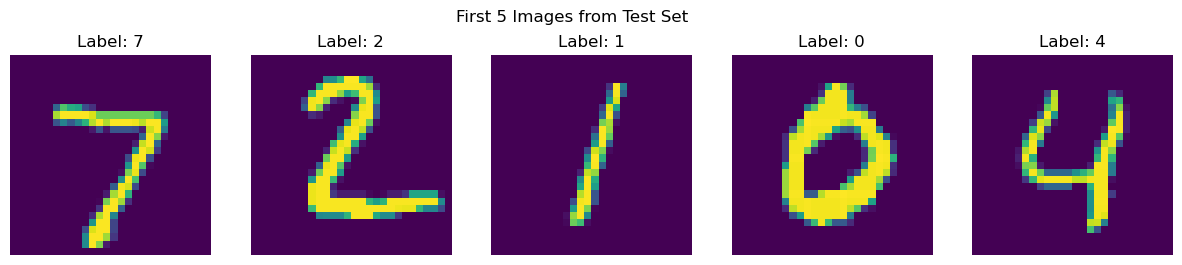

Displaying adversarial images...


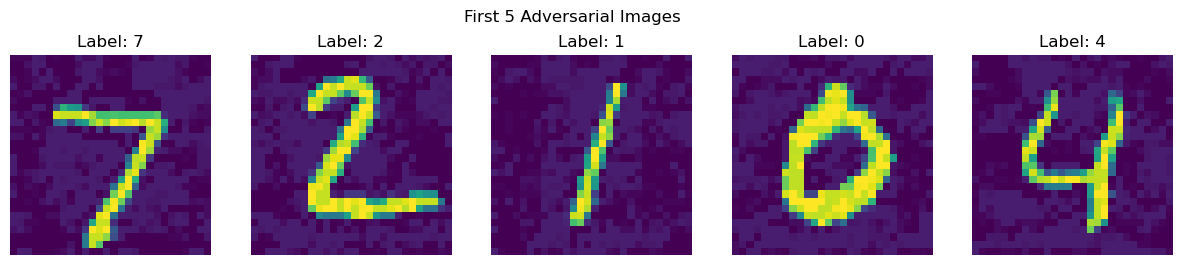

In [14]:
import matplotlib.pyplot as plt


def plot_images(images, labels, title=""):
    """
    显示前五张图片，自动处理 Cupy/NumPy、范围归一化等
    - images: (N, C, H, W)，可为 Cupy 或 NumPy
    - labels: (N,) 或 (N, C)
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)

    for i in range(5):
        ax = axes[i]

        # 取单张图片，并转 (H, W, C)
        img = images[i].transpose(1, 2, 0)

        # 如果是 cupy，则转为 numpy
        if hasattr(img, 'get'):
            img = img.get()

        # 如果像素最大值超过1，说明是 [0, 255]，就归一化
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)  # 保险剪裁，防止 overflow

        ax.imshow(img)
        # 标签显示
        label = labels[i]
        label_text = np.argmax(label) if len(label.shape) > 0 and label.shape[0] > 1 else label
        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.show()


print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")

# trades model

In [8]:
model= Model().load_model('best_model_trades/minst-trade-lenet/best_model.pickle')

Model loaded from: best_model_trades\minst-trade-lenet\best_model.pickle


In [9]:
loss_fn = CrossEntropy(model=model)
runner = RunnerM(model=model, loss=loss_fn, optimizer=None)

test_loss, test_acc = runner.evaluate(test_set, batch_size=128, loss_fn=loss_fn)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 0.0606, Test accuracy: 0.9819


In [10]:
from mynn.attack import pgd_kl_attack

adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=20/255,
    num_steps=10,
    step_size=4/255,
    batch_size=128,
    verbose=True,
)

test_set_adv = (adv_test_images, test_labels)

Generating Adversarial Examples: 100%|██████████████████████████████| 79/79 [00:17<00:00,  4.41it/s]


In [11]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 0.07038, Test accuracy: 0.97686
